In [1]:
%pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 40.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 19.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.9-cp312-cp312-macosx_10_9_universal2.whl size=419780 sha256=13dff81d1a61ed91aead1e5a5f0d45d21b87514b246d3801352d171aa167c774
  Stored in directory: /Users/hongyishi/Library/Caches/pip/wheels/43/ef/2d/2c51d496bf084945ffdf838b4cc8767b8ba1cc20eb41588831
Successfully built peewee

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
import datetime

In [5]:
# Get today's date
today = datetime.datetime.today().strftime('%Y-%m-%d')

# Download Tesla data from 2020 to today
tesla = yf.download('TSLA', start='2020-01-01', end=today)

# Check the latest row
print(tesla.tail())

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True
Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2025-04-02  282.760010  284.989990  251.270004  254.600006  212787800
2025-04-03  267.279999  276.299988  261.510010  265.290009  136174300
2025-04-04  239.429993  261.000000  236.000000  255.380005  181229400
2025-04-07  233.289993  252.000000  214.250000  223.779999  183453800
2025-04-08  221.860001  250.440002  217.800003  245.000000  170068600


In [6]:
# Save to CSV
tesla.to_csv('tesla_stock_data.csv')

# Model 1: LSTM

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0820 - val_loss: 0.0079
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0022
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


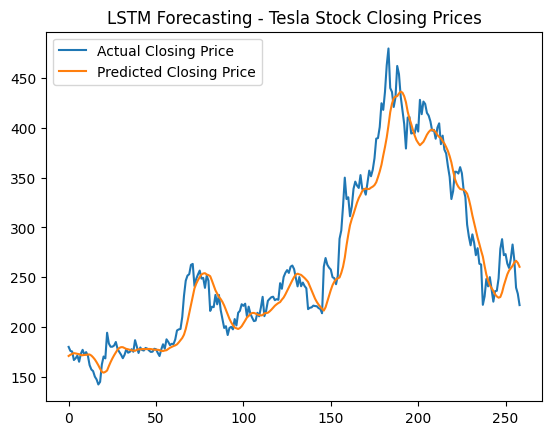

LSTM - RMSE: 21.57, MAE: 15.38, MAPE: 5.70%


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load and clean Tesla data
df = pd.read_csv('tesla_stock_data.csv')
df = df.iloc[2:]
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])
df = df.sort_values('Date')

# Prepare data
prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

X, y = create_sequences(prices_scaled)

split_idx = int(len(X) * 0.8)
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

# LSTM model
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Predictions
pred_scaled = model.predict(X_val)
pred = scaler.inverse_transform(pred_scaled)
true = scaler.inverse_transform(y_val)

# Plot
plt.plot(true, label='Actual Closing Price')
plt.plot(pred, label='Predicted Closing Price')
plt.title('LSTM Forecasting - Tesla Stock Closing Prices')
plt.legend()
plt.show()

# Evaluation
rmse = np.sqrt(mean_squared_error(true, pred))
mae = mean_absolute_error(true, pred)
mape = np.mean(np.abs((true - pred) / true)) * 100
print(f'LSTM - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%')

# Model 2: GRU

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0905 - val_loss: 0.0124
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3320e-04 - val_loss: 0.0014
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2351e-04 - val_loss: 0.0014
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3681e-04 - val_loss: 0.0014
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9724e-04 - val_loss: 0.0013
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5393e-04 - val_loss: 0.0012
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4001e-04 - val_loss: 0.0011
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2042e-04 - val_loss: 0.0012
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


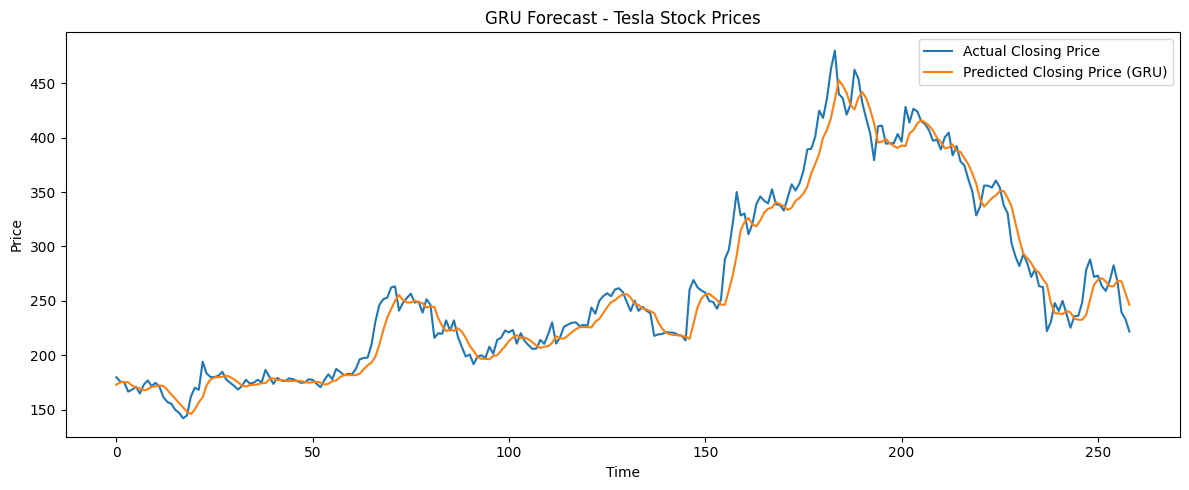

GRU - RMSE: 15.46, MAE: 10.97, MAPE: 4.08%


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load and clean Tesla data
df = pd.read_csv('tesla_stock_data.csv')
df = df.iloc[2:]
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])
df = df.sort_values('Date')

# Prepare data
prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

X, y = create_sequences(prices_scaled)

split_idx = int(len(X) * 0.8)
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

# GRU model
model = Sequential([
    GRU(64, input_shape=(X.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Predictions
y_pred_scaled = model.predict(X_val)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_val)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Actual Closing Price')
plt.plot(y_pred, label='Predicted Closing Price (GRU)')
plt.title('GRU Forecast - Tesla Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'GRU - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%')

# Model 3: Transformer

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0319 - val_loss: 0.0189
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0102
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0096
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0080
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0082
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0088
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - val_loss: 0.0090
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


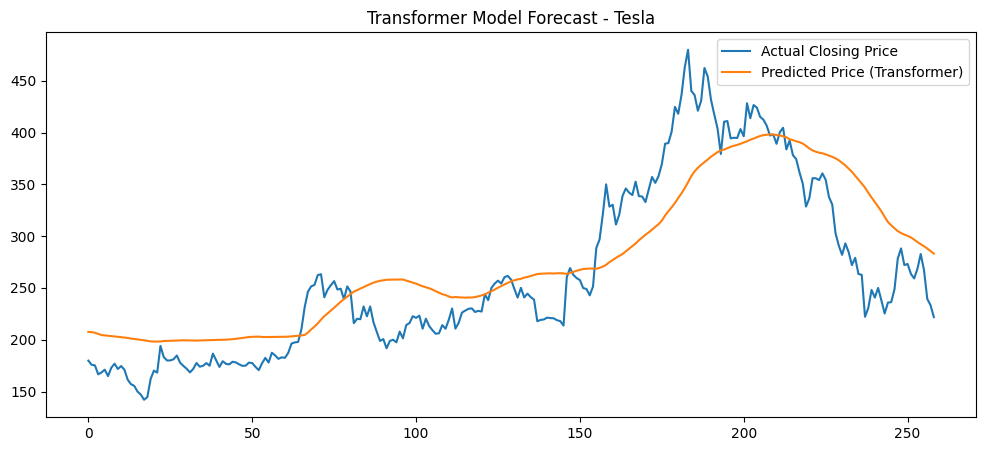

Transformer - RMSE: 43.14, MAE: 35.23, MAPE: 14.21%


In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load and clean Tesla data
df = pd.read_csv('tesla_stock_data.csv')
df = df.iloc[2:]
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])
df = df.sort_values('Date')

# Normalize prices
prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Sequence creation
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(prices_scaled, window=30)
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]

# Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

# Model Parameters
embed_dim = 32
num_heads = 2
ff_dim = 64

# Build Transformer Model
inputs = layers.Input(shape=(X.shape[1], 1))
x = layers.Dense(embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(20, activation="relu")(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Prediction
y_pred_scaled = model.predict(X_val)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_val)

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Actual Closing Price')
plt.plot(y_pred, label='Predicted Price (Transformer)')
plt.title('Transformer Model Forecast - Tesla')
plt.legend()
plt.show()

# Evaluation
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'Transformer - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%')

# Model 4: TCN

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.1435 - val_loss: 0.0267
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0110 - val_loss: 0.0054
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.6196e-04 - val_loss: 0.0018
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.7464e-04 - val_loss: 0.0019
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.7799e-04 - val_loss: 0.0014
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


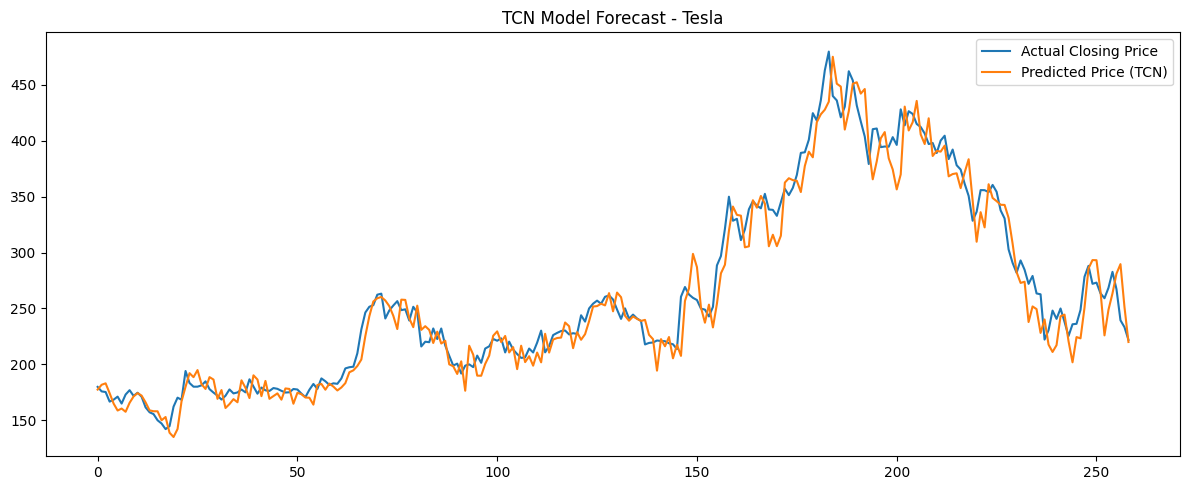

TCN - RMSE: 17.34, MAE: 13.36, MAPE: 5.01%


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from tcn import TCN

# Load and clean Tesla data
df = pd.read_csv('tesla_stock_data.csv')
df = df.iloc[2:]
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])
df = df.sort_values('Date')

# Prepare data
prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Sequence creation
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(prices_scaled)
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]

# Build TCN model
model = Sequential()
model.add(TCN(input_shape=(X.shape[1], 1)))  # Univariate input
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Prediction
y_pred_scaled = model.predict(X_val)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_val)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Actual Closing Price')
plt.plot(y_pred, label='Predicted Price (TCN)')
plt.title('TCN Model Forecast - Tesla')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'TCN - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%')

# Model 5: N-BEATS

| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=1, share_thetas=True) at @11299630512
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=1, share_thetas=True) at @11295224896
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=1, backcast_length=30, forecast_length=1, share_thetas=True) at @11291969008
     | -- SeasonalityBlock(units=128, thetas_dim=1, backcast_length=30, forecast_length=1, share_thetas=True) at @11294133808


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([5, 1, 1])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.0771
Epoch 2, Loss: 0.0309
Epoch 3, Loss: 0.0318
Epoch 4, Loss: 0.0339
Epoch 5, Loss: 0.0324
Epoch 6, Loss: 0.0302
Epoch 7, Loss: 0.0337
Epoch 8, Loss: 0.0321
Epoch 9, Loss: 0.0321
Epoch 10, Loss: 0.0314


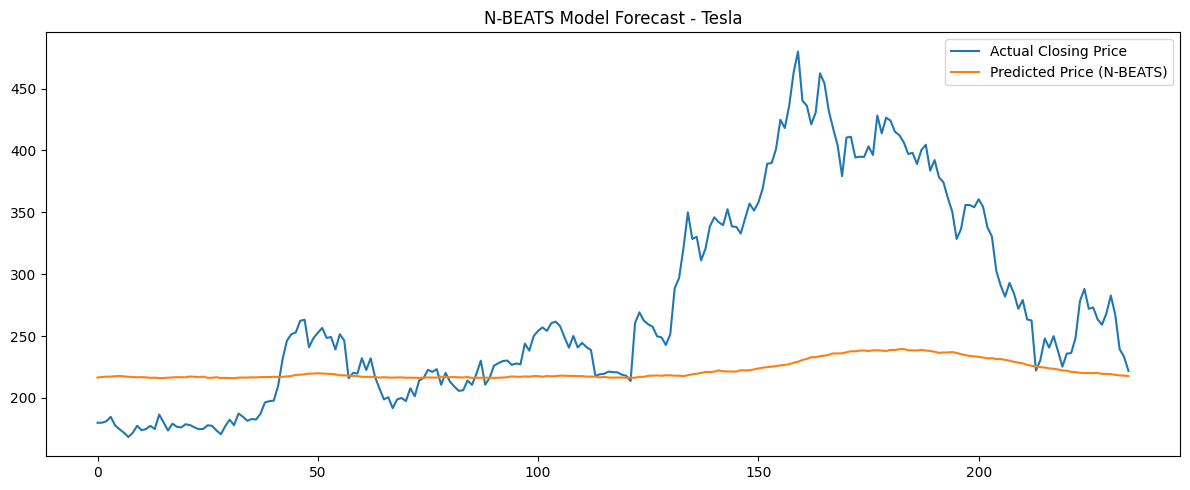

N-BEATS - RMSE: 90.33, MAE: 65.17, MAPE: 20.45%


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from nbeats_pytorch.model import NBeatsNet

# Load and clean Tesla stock data
df = pd.read_csv('tesla_stock_data.csv')
df = df.iloc[2:]
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])
df = df.sort_values('Date')

# Normalize close prices
prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Sequence parameters
WINDOW = 30
HORIZON = 1

# Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window, horizon):
        self.X, self.y = [], []
        for i in range(len(data) - window - horizon + 1):
            self.X.append(data[i:i+window])
            self.y.append(data[i+window:i+window+horizon])
        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Train/test split
split = int(len(prices_scaled) * 0.8)
train_dataset = TimeSeriesDataset(prices_scaled[:split], WINDOW, HORIZON)
val_dataset = TimeSeriesDataset(prices_scaled[split:], WINDOW, HORIZON)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
model = NBeatsNet(
    stack_types=('trend', 'seasonality'),
    nb_blocks_per_stack=2,
    forecast_length=HORIZON,
    backcast_length=WINDOW,
    thetas_dim=(4, 8),
    hidden_layer_units=128
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        backcast, forecast = model(X_batch)
        loss = loss_fn(forecast, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {np.mean(train_losses):.4f}")

# Validation
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        _, forecast = model(X_batch)
        predictions.extend(forecast.cpu().numpy())
        actuals.extend(y_batch.numpy())

# Rescale
y_pred = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
y_true = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Actual Closing Price')
plt.plot(y_pred, label='Predicted Price (N-BEATS)')
plt.title('N-BEATS Model Forecast - Tesla')
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'N-BEATS - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%')

# Model 6: ARIMA

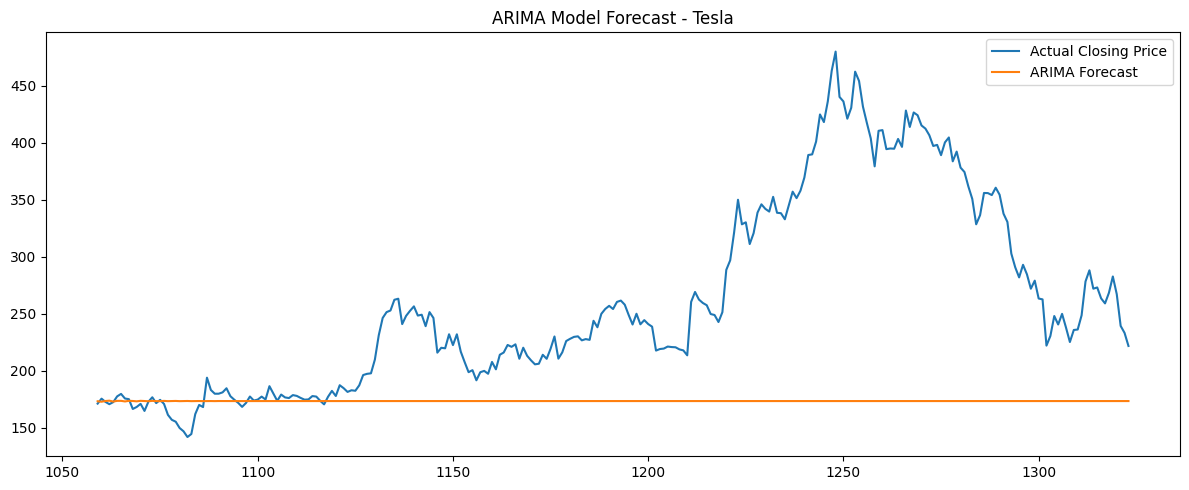

ARIMA - RMSE: 120.70, MAE: 88.89, MAPE: 28.15%


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load and clean Tesla stock data
df = pd.read_csv('tesla_stock_data.csv')
df = df.iloc[2:]
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])
df = df.sort_values('Date').reset_index(drop=True)

# Use only the 'Close' prices
close_prices = df['Close']

# Split into training and testing sets
train_size = int(len(close_prices) * 0.8)
train, test = close_prices[:train_size], close_prices[train_size:]

# Fit ARIMA model (you can tune the order as needed)
model = ARIMA(train, order=(5, 1, 2)) 
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(test.index, test.values, label='Actual Closing Price')
plt.plot(test.index, forecast.values, label='ARIMA Forecast')
plt.title('ARIMA Model Forecast - Tesla')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test.values - forecast.values) / test.values)) * 100

print(f'ARIMA - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%')

# Model 7: SARIMA

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported

SARIMA - RMSE: 102.53, MAE: 71.64, MAPE: nan%


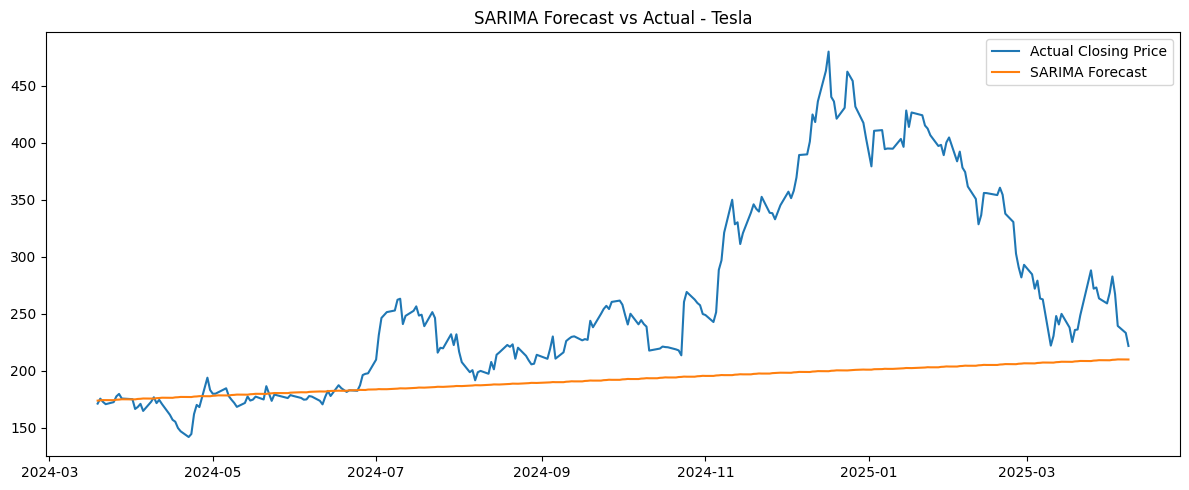

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load and clean Tesla stock data
df = pd.read_csv('tesla_stock_data.csv')
df = df.iloc[2:]
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])
df = df.sort_values('Date')

# Set datetime index
df.set_index('Date', inplace=True)

# Use only 'Close' column
series = df['Close']

# Split data
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Fit SARIMA model
model = SARIMAX(train, 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 5),  # Assuming weekly cycle (5 trading days)
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)

# Forecast
forecast = results.forecast(steps=len(test))

# Evaluate
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f'SARIMA - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%')

# Plot
plt.figure(figsize=(12, 5))
plt.plot(test.index, test.values, label='Actual Closing Price')
plt.plot(test.index, forecast.values, label='SARIMA Forecast')
plt.title('SARIMA Forecast vs Actual - Tesla')
plt.legend()
plt.tight_layout()
plt.show()

# Model 8: Prophet

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
18:51:52 - cmdstanpy - INFO - Chain [1] start processing
18:51:52 - cmdstanpy - INFO - Chain [1] done processing


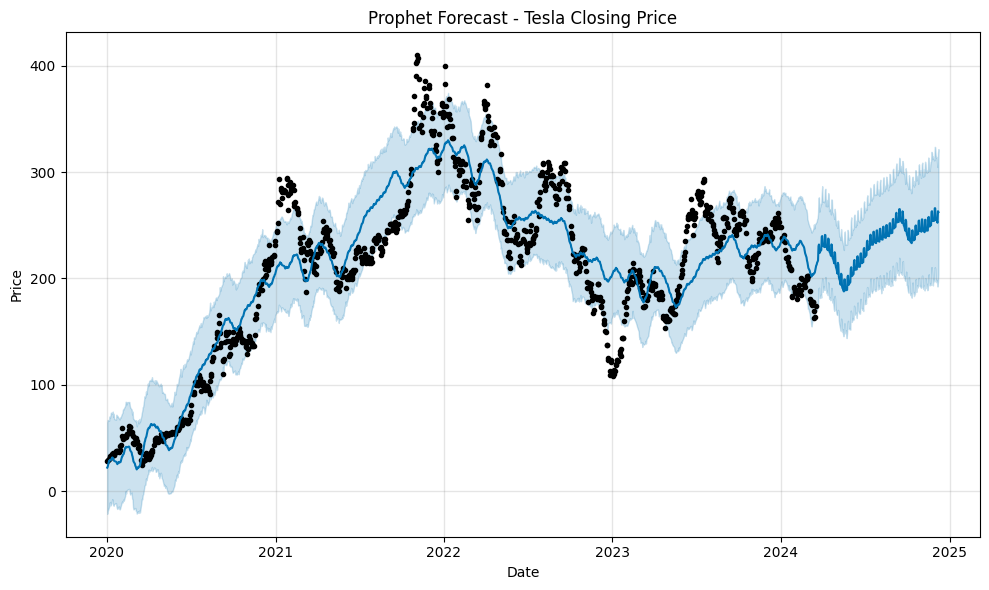

Prophet - RMSE: 79.34, MAE: 56.58, MAPE: 15.77%


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load and clean Tesla data
df = pd.read_csv('tesla_stock_data.csv')
df = df.iloc[2:]
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])
df = df.sort_values('Date')

# Rename for Prophet
df_prophet = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Split into train/test
train_size = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

# Fit Prophet model
model = Prophet()
model.fit(train_df)

# Forecast into future
future = model.make_future_dataframe(periods=len(test_df))
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title('Prophet Forecast - Tesla Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Evaluate performance
pred = forecast[['ds', 'yhat']].set_index('ds').iloc[-len(test_df):]
actual = test_df.set_index('ds')

rmse = np.sqrt(mean_squared_error(actual['y'], pred['yhat']))
mae = mean_absolute_error(actual['y'], pred['yhat'])
mape = np.mean(np.abs((actual['y'] - pred['yhat']) / actual['y'])) * 100

print(f'Prophet - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%')

# Model 9: XGBoost

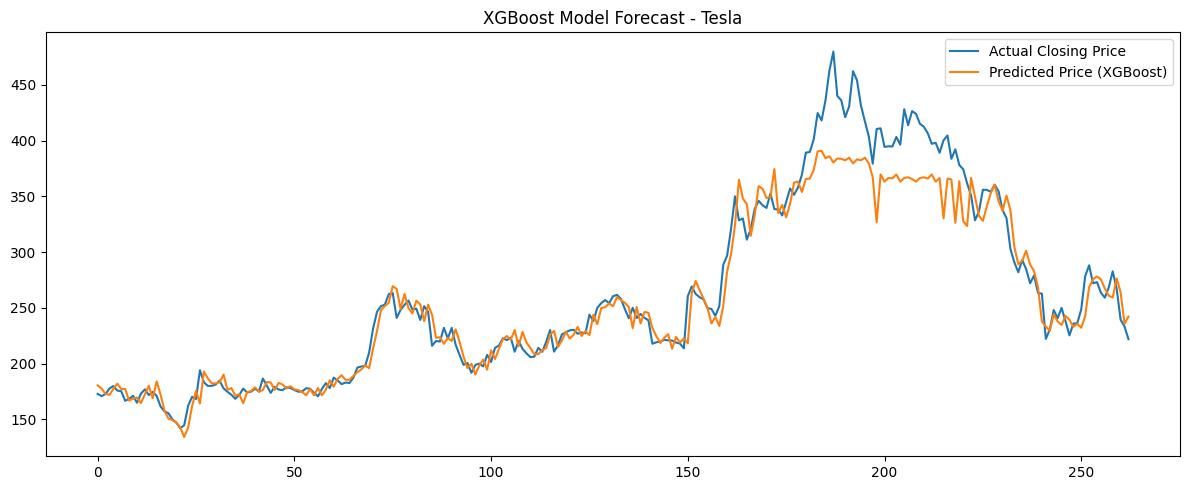

XGBoost - RMSE: 22.19, MAE: 14.28, MAPE: 4.70%


In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load and clean Tesla stock data
df = pd.read_csv('tesla_stock_data.csv')
df = df.iloc[2:]
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])
df = df.sort_values('Date').reset_index(drop=True)

# Feature engineering
df['lag_1'] = df['Close'].shift(1)
df['lag_5'] = df['Close'].shift(5)
df['lag_10'] = df['Close'].shift(10)

df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month

# Drop missing values from lag features
df = df.dropna()

# Define features and target
features = ['lag_1', 'lag_5', 'lag_10', 'dayofweek', 'month']
target = 'Close'

X = df[features]
y = df[target]

# Split into training and validation
train_size = int(len(X) * 0.8)
X_train, X_val = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_val = y.iloc[:train_size], y.iloc[train_size:]

# Train model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_val.values, label='Actual Closing Price')
plt.plot(y_pred, label='Predicted Price (XGBoost)')
plt.title('XGBoost Model Forecast - Tesla')
plt.legend()
plt.tight_layout()
plt.show()

print(f'XGBoost - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%')